In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cuda')

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

traiset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
trailoader = torch.utils.data.DataLoader(traiset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

clsses = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [4]:
trailoader.dataset.data.shape

(50000, 32, 32, 3)

In [5]:
testloader.dataset.data.shape

(10000, 32, 32, 3)

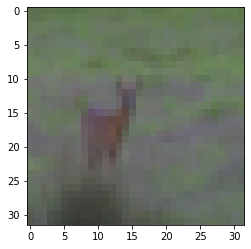

In [14]:
plt.imshow(trailoader.dataset.data[420], cmap='gray')

In [20]:
class MyConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.fc1 = nn.Linear(128*6*6, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 128*6*6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
net = MyConvNet()
batch = []
batch = next(iter(trailoader))
net.forward(torch.FloatTensor(batch[0]))

torch.Size([128, 128, 6, 6])


tensor([[-0.0341,  0.0254,  0.0027,  ...,  0.1104,  0.0261,  0.0357],
        [-0.0467,  0.0249,  0.0022,  ...,  0.1160,  0.0373,  0.0472],
        [-0.0314,  0.0310,  0.0120,  ...,  0.1100,  0.0267,  0.0306],
        ...,
        [-0.0397,  0.0292,  0.0224,  ...,  0.1009,  0.0229,  0.0314],
        [-0.0263,  0.0245, -0.0044,  ...,  0.1190,  0.0099,  0.0282],
        [-0.0313,  0.0436,  0.0136,  ...,  0.0988,  0.0333,  0.0081]],
       grad_fn=<AddmmBackward0>)

In [ ]:
from tqdm import tqdm_notebook

net = MyConvNet().to(device)

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

losses = []

for epoch in tqdm_notebook(range(10)):
    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trailoader)):
        X_batch, y_batch = batch

        optimizer.zero_grad()

        y_pred = net(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 2000 == 1999:
            print(f'[{epoch+1} {i+1}] loss: {running_loss / 2000}')
            running_loss = 0.0

print('Обучение закончено')

In [22]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images.to(device))
        _, predicted = torch.max(y_pred, 1)

        c = (predicted.cpu().detach() == labels)
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f'Accuracy of {clsses[i]}: {100 * class_correct[i] / class_total[i]}')

Accuracy of plane: 69.44444444444444
Accuracy of car: 79.48717948717949
Accuracy of bird: 40.229885057471265
Accuracy of cat: 42.5
Accuracy of deer: 54.166666666666664
Accuracy of dog: 41.0958904109589
Accuracy of frog: 79.7752808988764
Accuracy of horse: 75.64102564102564
Accuracy of ship: 75.5813953488372
Accuracy of truck: 60.0
